This notebook explores the idea of evaluating a group of people within iSAID (the experimental "Integrated Science Assessment Information Database). iSAID gathers together a number of information sources from various data systems (all public at this point) about scientific assets of importance to our work in the USGS. We've started with our people, the most important pool of assets we have have, and will expand into other areas in due course.

The iSAID database is a cached source of information sources where we've done a little bit of work to synthesize useful information and entry points by rectifying issues with identifiers and smoothing over back-end technologies that are not very robust or stable. It is made available online to experiment what it would look like if we could tap these systems more directly and also to look at the possibility of spinning the cache up in some sort of sustainable state.

This notebook explores CDI members as a group, pulling together specific types of information that might be useful in characterizing the total strengths and potential expertise gaps within a given group of people. It exercises the iSAID database functionality built into the pylinkedcmd package against an experimental GraphQL API where recent information has been cached.

### Running the code

If you are running this on Google Colab or some other Jupyter Hub instance, you will need to install the following:

```!pip install git+git://github.com/skybristol/pylinkedcmd@dev```

You may also need to install wordcloud and other packages depending on the platform and environment. You will also need the Excel file ("cdi-all-200930.xlsx") dropped into the local directory or otherwise point at some other file and process out a list of email addresses.

Note: I did not go back through the full suite of email validation checks that I did in a previous version of this notebook.

In [1]:
%matplotlib inline
import pylinkedcmd
import pandas as pd
import validators
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import matplotlib.pyplot as plt

def plot_cloud(wordcloud):
    plt.figure(figsize=(40, 30))
    plt.imshow(wordcloud) 
    plt.axis("off");

wc = WordCloud(
    width = 3000, 
    height = 2000, 
    random_state=1, 
    background_color='salmon', 
    colormap='Pastel1', 
    collocations=False, 
    stopwords = STOPWORDS
)

cmd_isaid = pylinkedcmd.pylinkedcmd.Isaid()

In [2]:
cdi_members = pd.read_excel("cdi-all-200930.xlsx", header=None, index_col=False)[0].to_list()
usgs_cdi_members = [i.strip().lower() for i in cdi_members if i.split("@")[-1].strip() in ["usgs.gov", "contractor.usgs.gov"]]

print(len(usgs_cdi_members), len(list(set(usgs_cdi_members))))

check_usgs_cdi_members = [(i, validators.email(i)) for i in usgs_cdi_members]
print([i for i in check_usgs_cdi_members if not i[1]])

1219 1219
[]


In [3]:
cdi_members

['aakbariasanjan@usra.edu',
 'aakobaya@usgs.gov',
 'aallwardt@usgs.gov',
 'aalorenz@usgs.gov',
 'aappling@usgs.gov',
 'aaretxabaleta@usgs.gov',
 'aaunins@usgs.gov',
 'abaker@usgs.gov',
 'abamzai@usgs.gov',
 'abcooper@usgs.gov',
 'abenthem@usgs.gov',
 'abigail.rosenberg@usmc.mil',
 'abock@usgs.gov',
 'abozimowski@usgs.gov',
 'abrayton@contractor.usgs.gov',
 'aclaycomb@usgs.gov',
 'acory@contractor.usgs.gov',
 'acronin@nsf.gov',
 'adam.smith2@canada.ca',
 'adiefenbach@usgs.gov',
 'Adrienne.stephens@aecom.com',
 'aeast@usgs.gov',
 'aecravens@usgs.gov',
 'afge3403usgs@usgs.gov',
 'afiore@usgs.gov',
 'afox@usgs.gov',
 'afriesz@contractor.usgs.gov',
 'agahala@usgs.gov',
 'agalanter@usgs.gov',
 'agarcia@usgs.gov',
 'agellis@usgs.gov',
 'agilmer@usgs.gov',
 'agrant@usgs.gov',
 'ahaj@usgs.gov',
 'aharris@usgs.gov',
 'ahbell@usgs.gov',
 'aheadman@usgs.gov',
 'ahenson@usgs.gov',
 'ahrea@usgs.gov',
 'ahudson@usgs.gov',
 'aikatz@usgs.gov',
 'ajanetos@contractor.usgs.gov',
 'ajason@usgs.gov',
 'ajly

In [4]:
%%time
cdi_members = cmd_isaid.assemble_person_record(cdi_members, datatypes=["claims"])

CPU times: user 645 ms, sys: 189 ms, total: 834 ms
Wall time: 5min 9s


### A note about the data model
I've ended up reworking the data model and processing in the iSAID framework significantly as I've started trying to make sense of all the information we can bring together from diverse sources. I am continuing to like the idea of the basic WikiData model of entities with claims that are referenced and qualified and have been working toward that concept. The underlying iSAID database now has the following elements:

* People (aka Directory) - Unique identifiers and basic details about people of interest, starting with all active employees in the USGS, pulled from Active Directory via the ScienceBase Directory sync.
* Assets - Generalized high level model of ultimately any type of scientific asset. I've started with publications and data, sourcing from the USGS Pubs Warehouse and the ScienceBase Catalog, respectively. I've generalized and abstracted to just a few key properties aligned with the schema.org/CreativeWork schema. The main thing I do in processing records for this is key in on the identifiers of people and organizations and their roles in relation to the assets, using the Directory source to align unique, resolvable identifiers for linkability across resources.
* Claims - Following the basic WikiData claim/statement model, these are modeled as subject, predicate (property), object records with a reference and qualifiers. Currently, references are limited to a reference (by URL) to an asset, which is where the claims are currently derived. This will need to expand in future to support multiple references, including reference to source processing details. Qualifiers always include a date that the claim is considered valid or applicable and may include further detail on the classification of the claimed property/relationship between subject and object. For instance, these include the unresolvable assertions of tags/terms applied to data releases that can be used to run normalization routines on those concepts.
* WikiData Entities and Claims - These are mainly included as a placeholder for the moment while I work toward whether or not to leverage WikiData in an operational sense. We have 2000+ WikiData entities representing people that we have identified, and these entities do have some interesting claims for future examination such as linkage to other identifier systems that can do interesting things like open up additional publications and resources published by authors outside of their USGS scope. There are also additional entities in WikiData for USGS organizations, and more interestingly, other important assets like scientific models and platforms like research vessels.

Note:  Organizations are currently incidental in this model and inherent only as names and identifiers associated with people and pulled in as claims about assets. I have not yet tackled the issue of normalizing organizations against a master source, partly because all of the master sources, including internal systems currently in use, are imperfect with respect to a temporal record.

It currently takes a little while to run the query to assemble everything to look at for a group like in this example, so we will want to employ some type of optimization scheme. My current working code uses a GraphQL end point operating against a PostgreSQL back end. Running queries of similar scope on something like the WikiData SPARQL interface also take some time to execute and process.

In the following sections, we look at the type of claims available for members of the group as subjects. Running the query for members as objects is also interesting and worth further examination, but subject-focused searches make sense for the immediate exercise. We then pull out the object labels for these relationships and visualize values with word clouds. It is important to note that until work is done to align concepts with more specific vocabularies and registry sources, the information can't be used for much more than a simple overview.

In [5]:
list(set([i["property_label"] for i in cdi_members["claims"]]))

['data release co-developer',
 'organization affiliation',
 'USGS Cost Center association from publication',
 'data release metadata tag',
 'expertise',
 'job title',
 'organization data release affiliation',
 'coauthor']

In [10]:
cdi_job_titles = [
    i["object_label"] for i in cdi_members["claims"] 
    if i["property_label"] == "job title"
]
cdi_expertise_terms = [
    i["object_label"] for i in cdi_members["claims"] 
    if i["property_label"] == "expertise"
]
cdi_org_affiliation = [
    i["object_label"] for i in cdi_members["claims"] 
    if i["property_label"] in [
        "organization affiliation", 
        "USGS Cost Center association from publication",
        "organization data release affiliation"
    ]
]
cdi_data_tags = [
    i["object_label"] for i in cdi_members["claims"] 
    if i["property_label"] == "data release metadata tag"
]
print("Number of unique or shared job titles: ", len(list(set(cdi_job_titles))))
print("Number of unique or shared expertise terms: ", len(list(set(cdi_expertise_terms))))
print("Number of unique or shared organization affiliations: ", len(list(set(cdi_org_affiliation))))
print("Number of unique or shared data tags: ", len(list(set(cdi_data_tags))))

Number of unique or shared job titles:  156
Number of unique or shared expertise terms:  1341
Number of unique or shared organization affiliations:  523
Number of unique or shared data tags:  7580


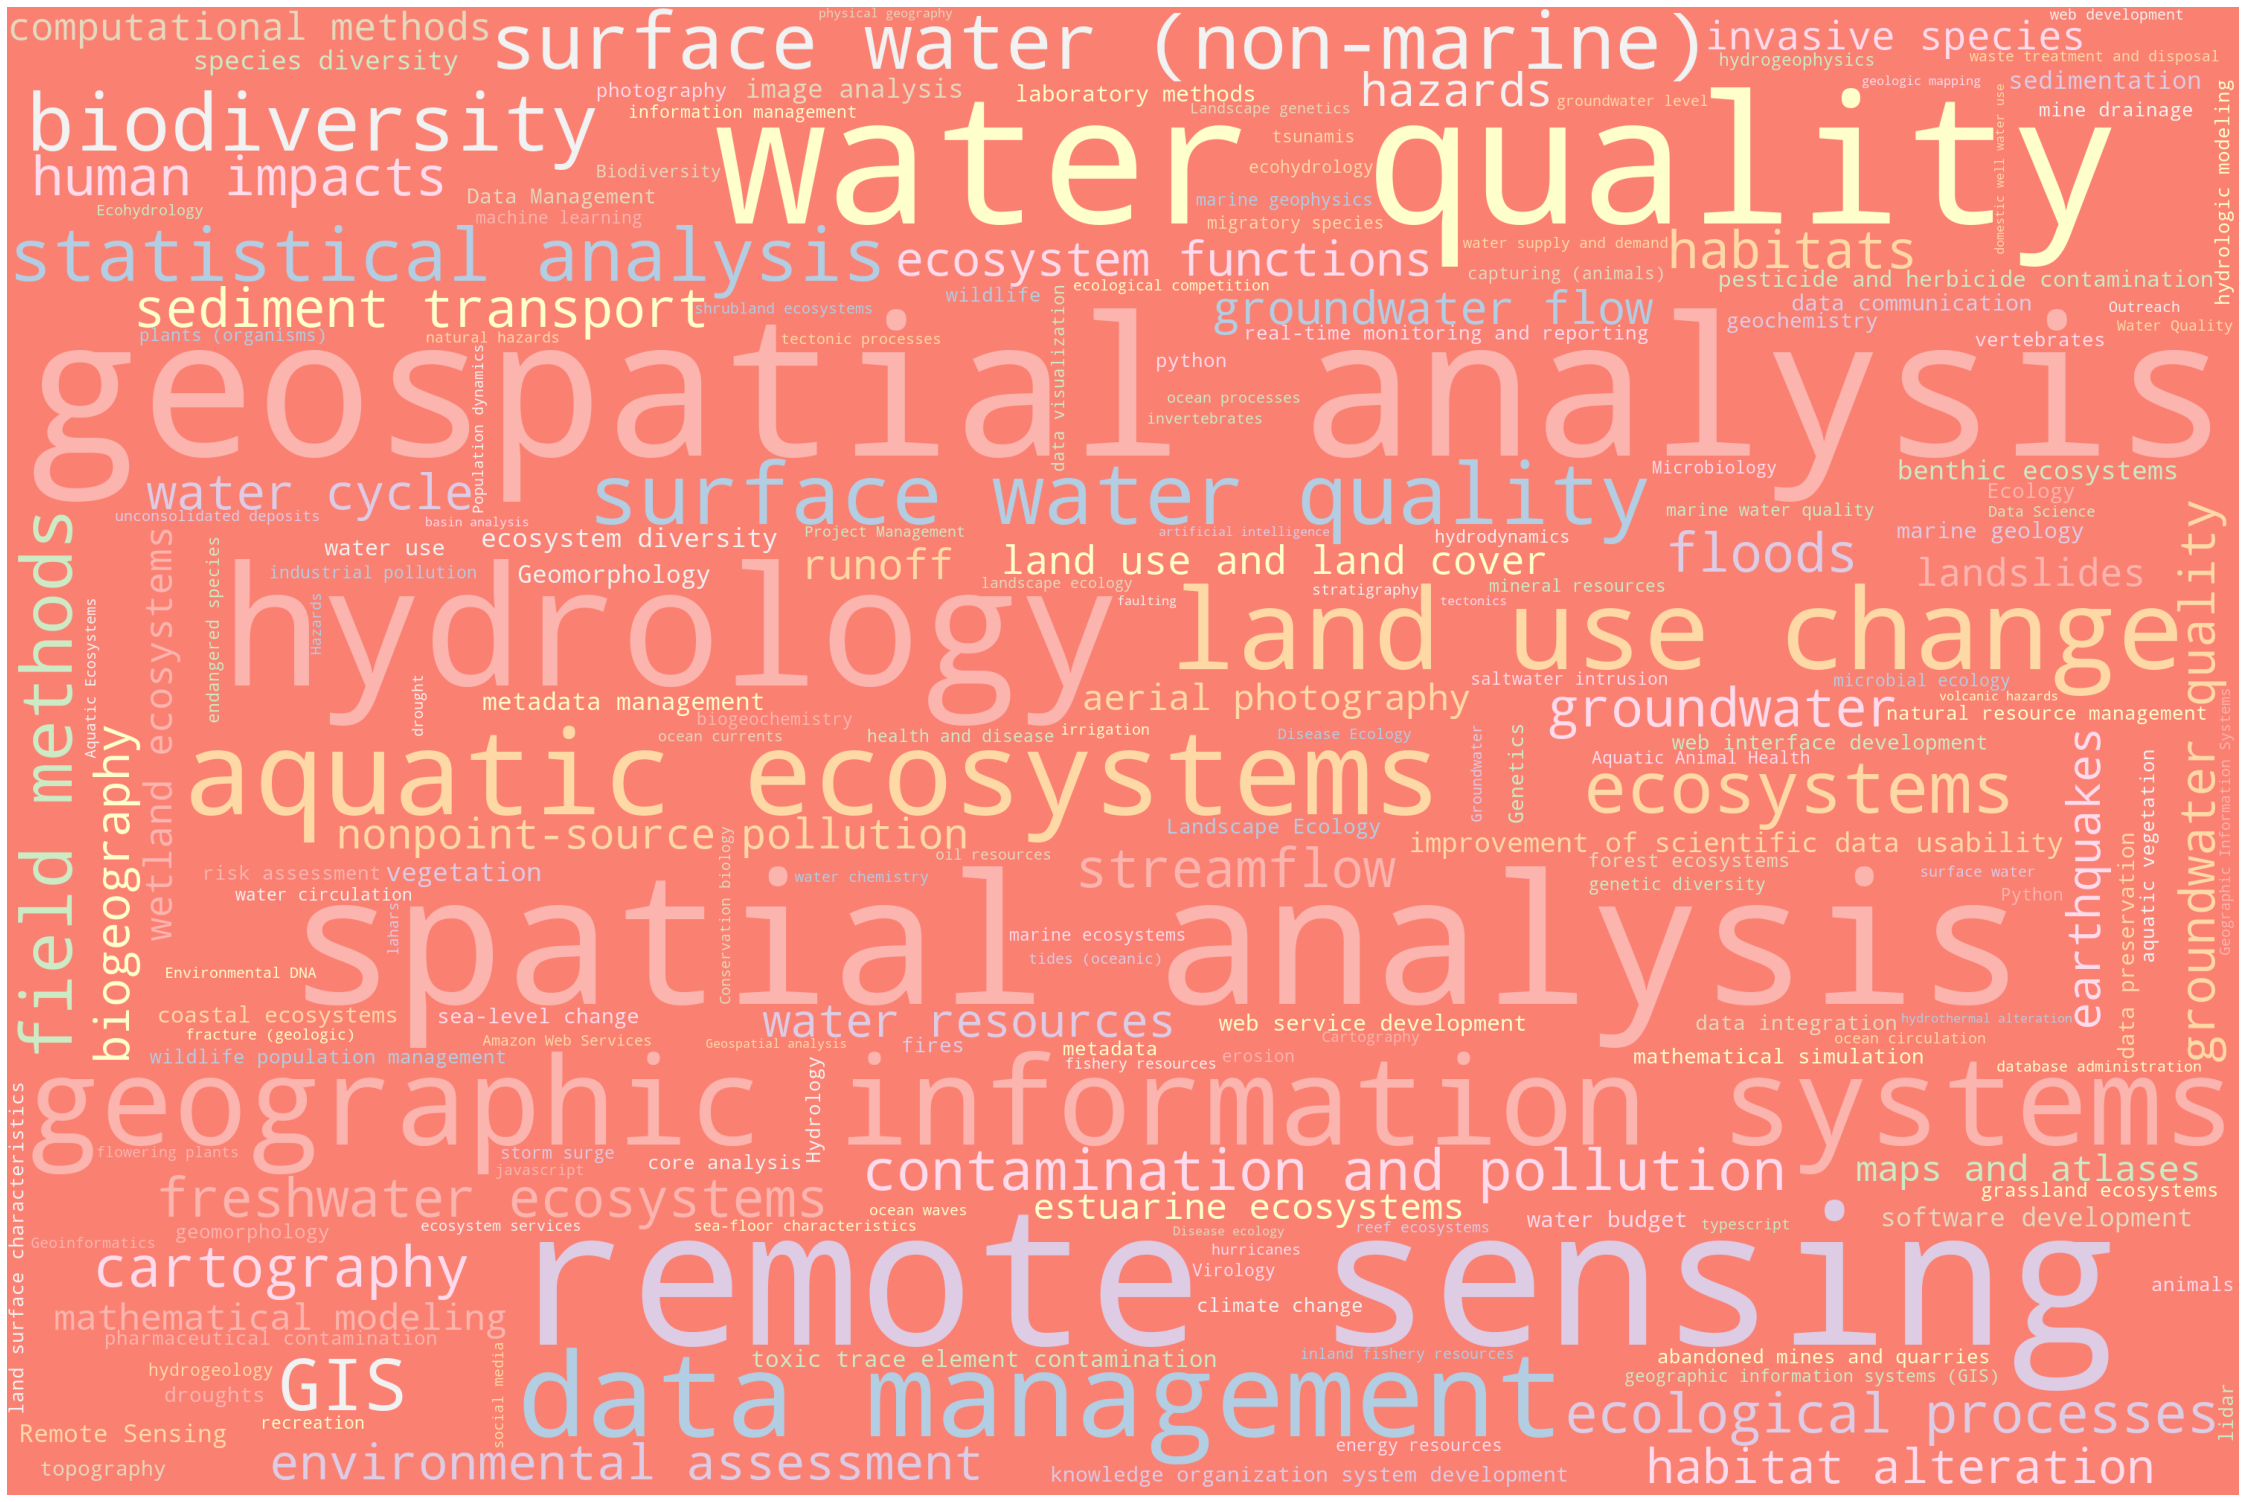

In [7]:
plot_cloud(wc.generate_from_frequencies(Counter(cdi_expertise_terms)))

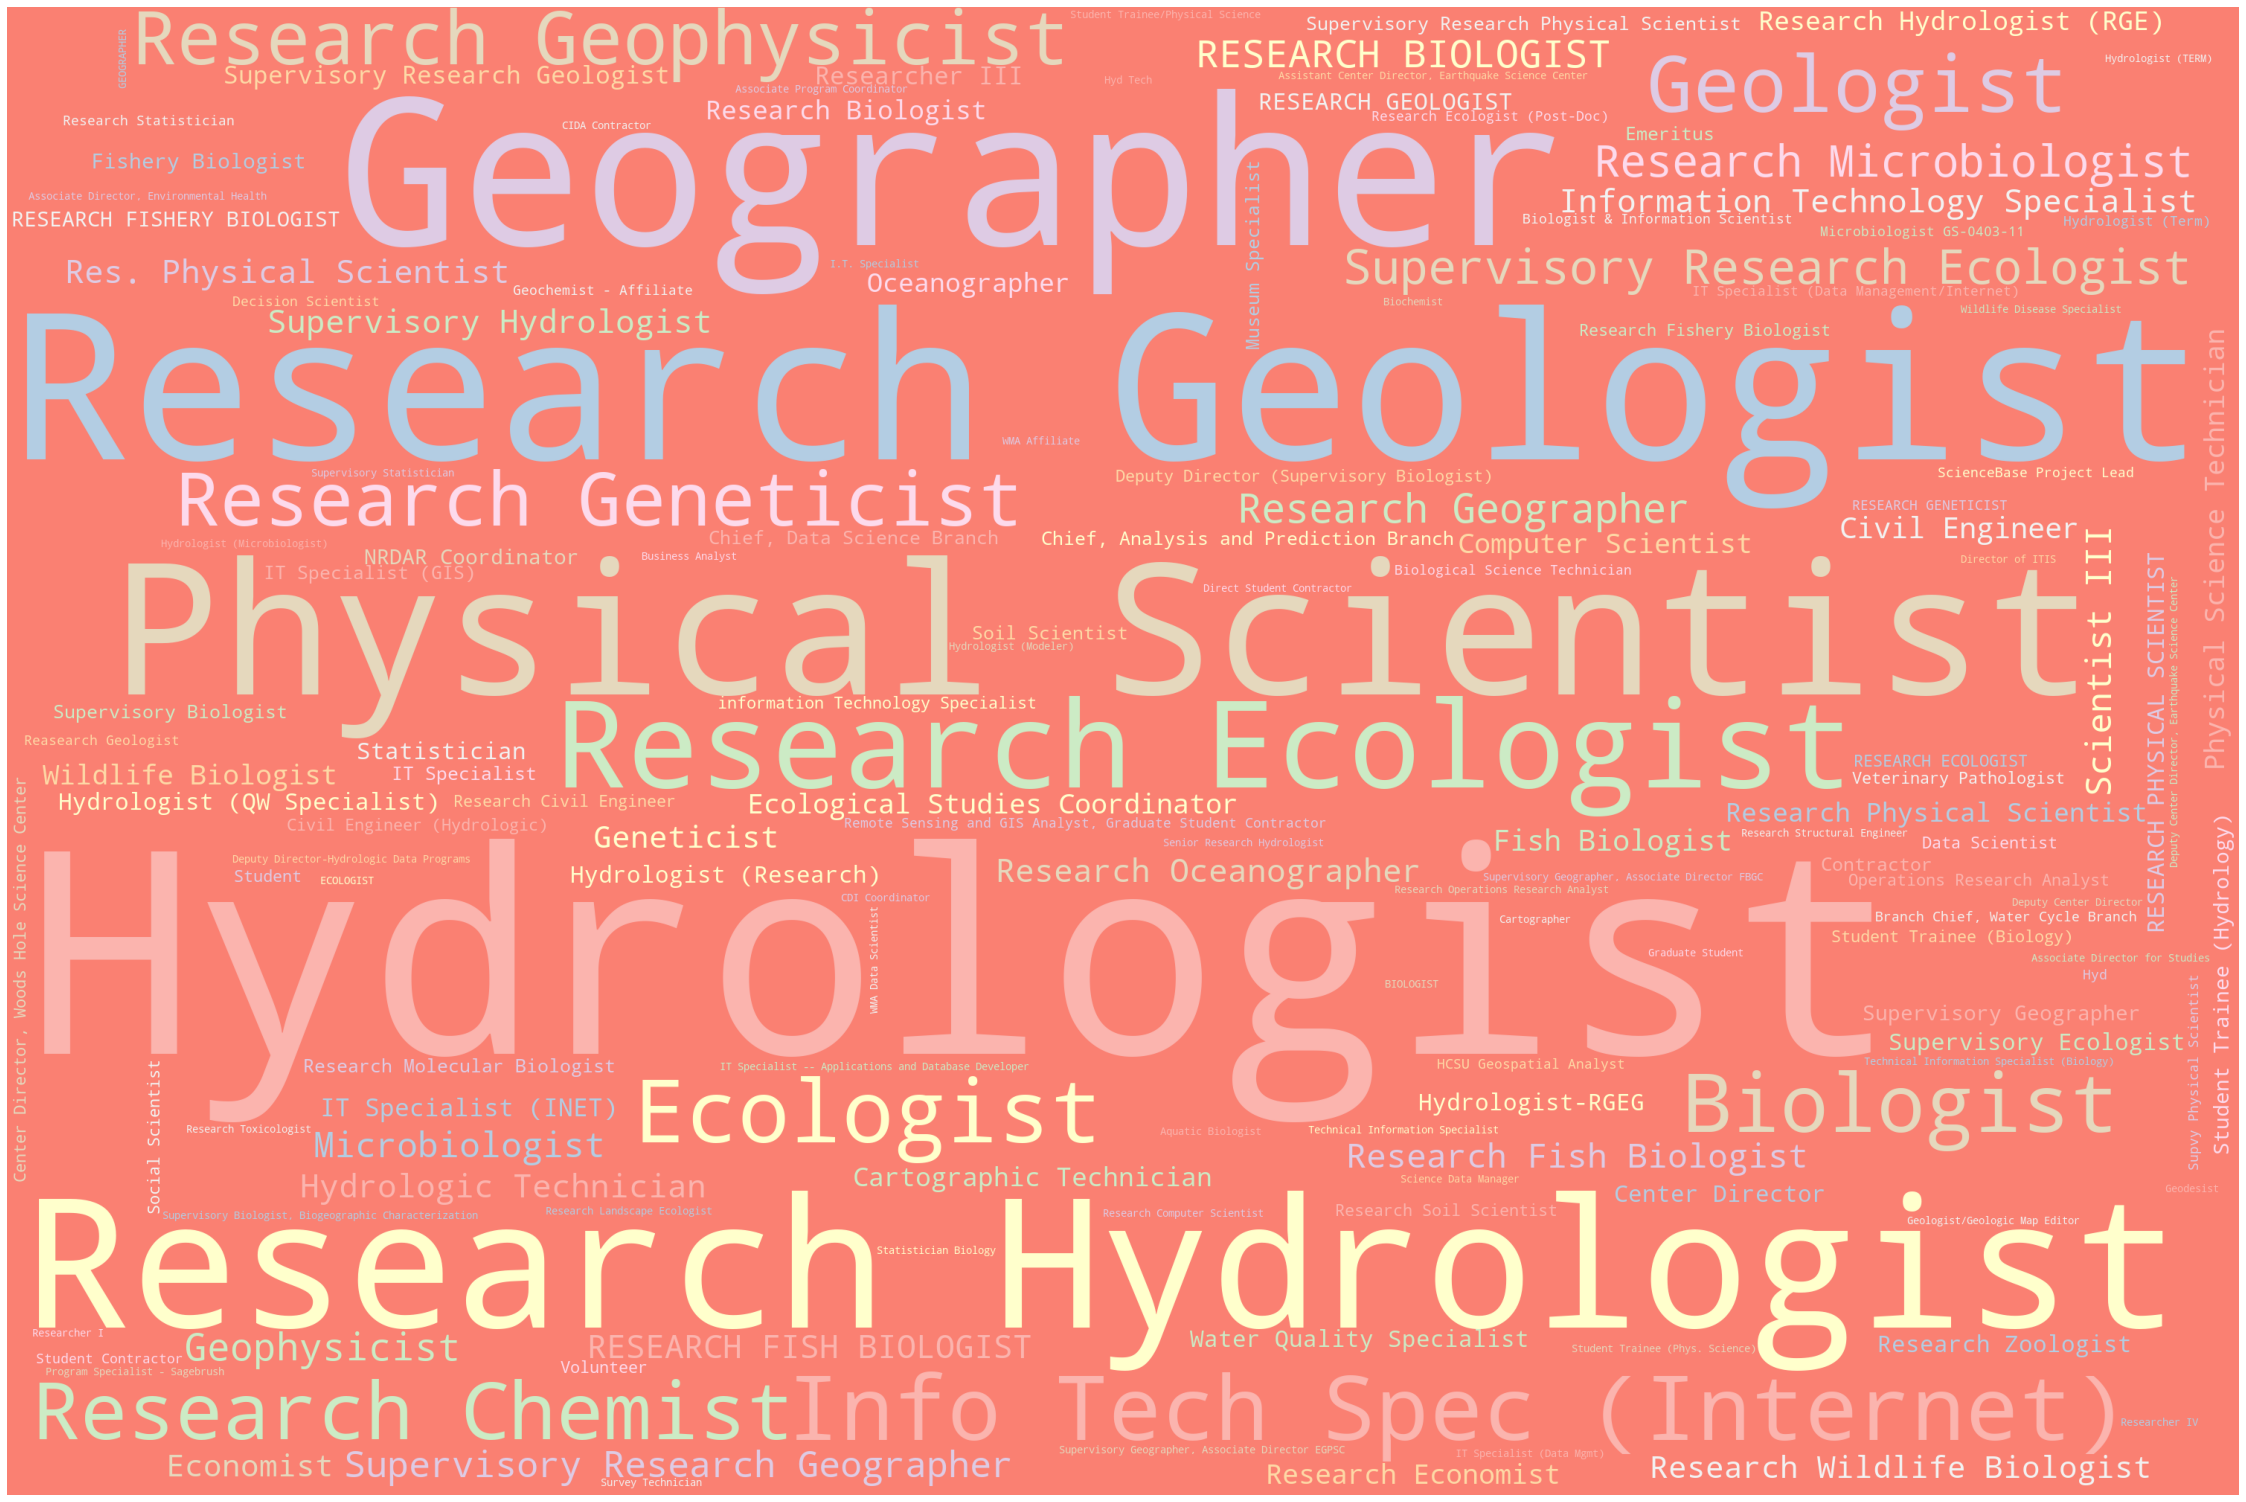

In [8]:
plot_cloud(wc.generate_from_frequencies(Counter(cdi_job_titles)))

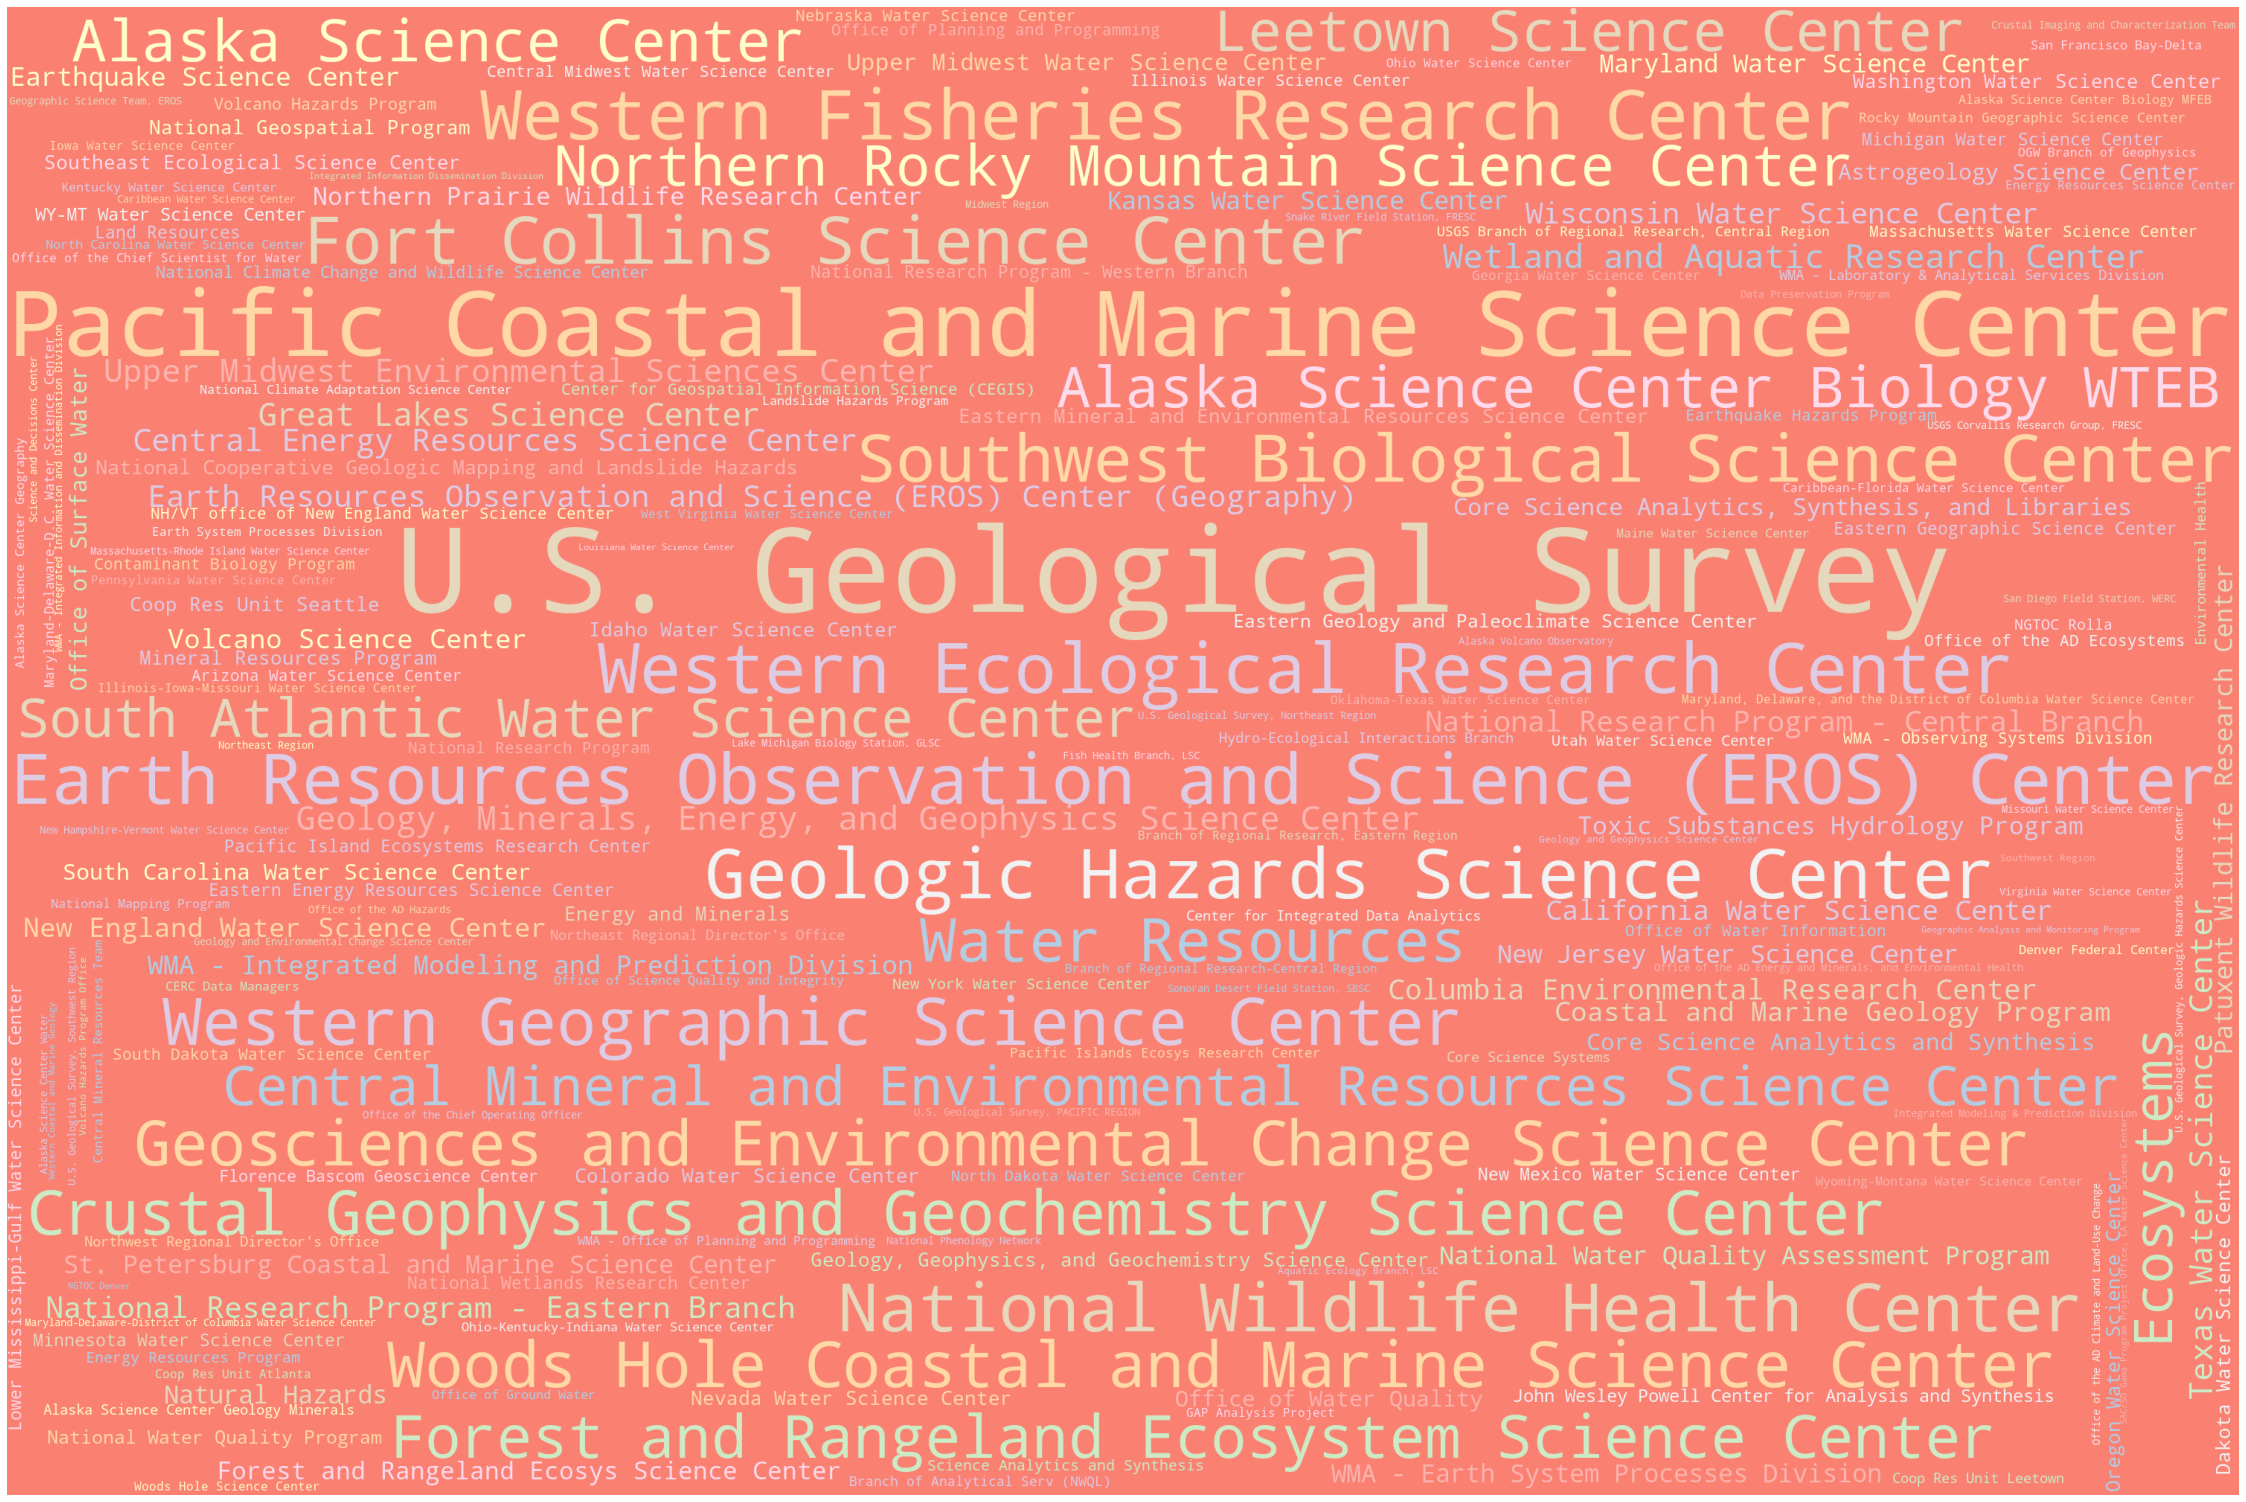

In [11]:
plot_cloud(wc.generate_from_frequencies(Counter(cdi_org_affiliation)))

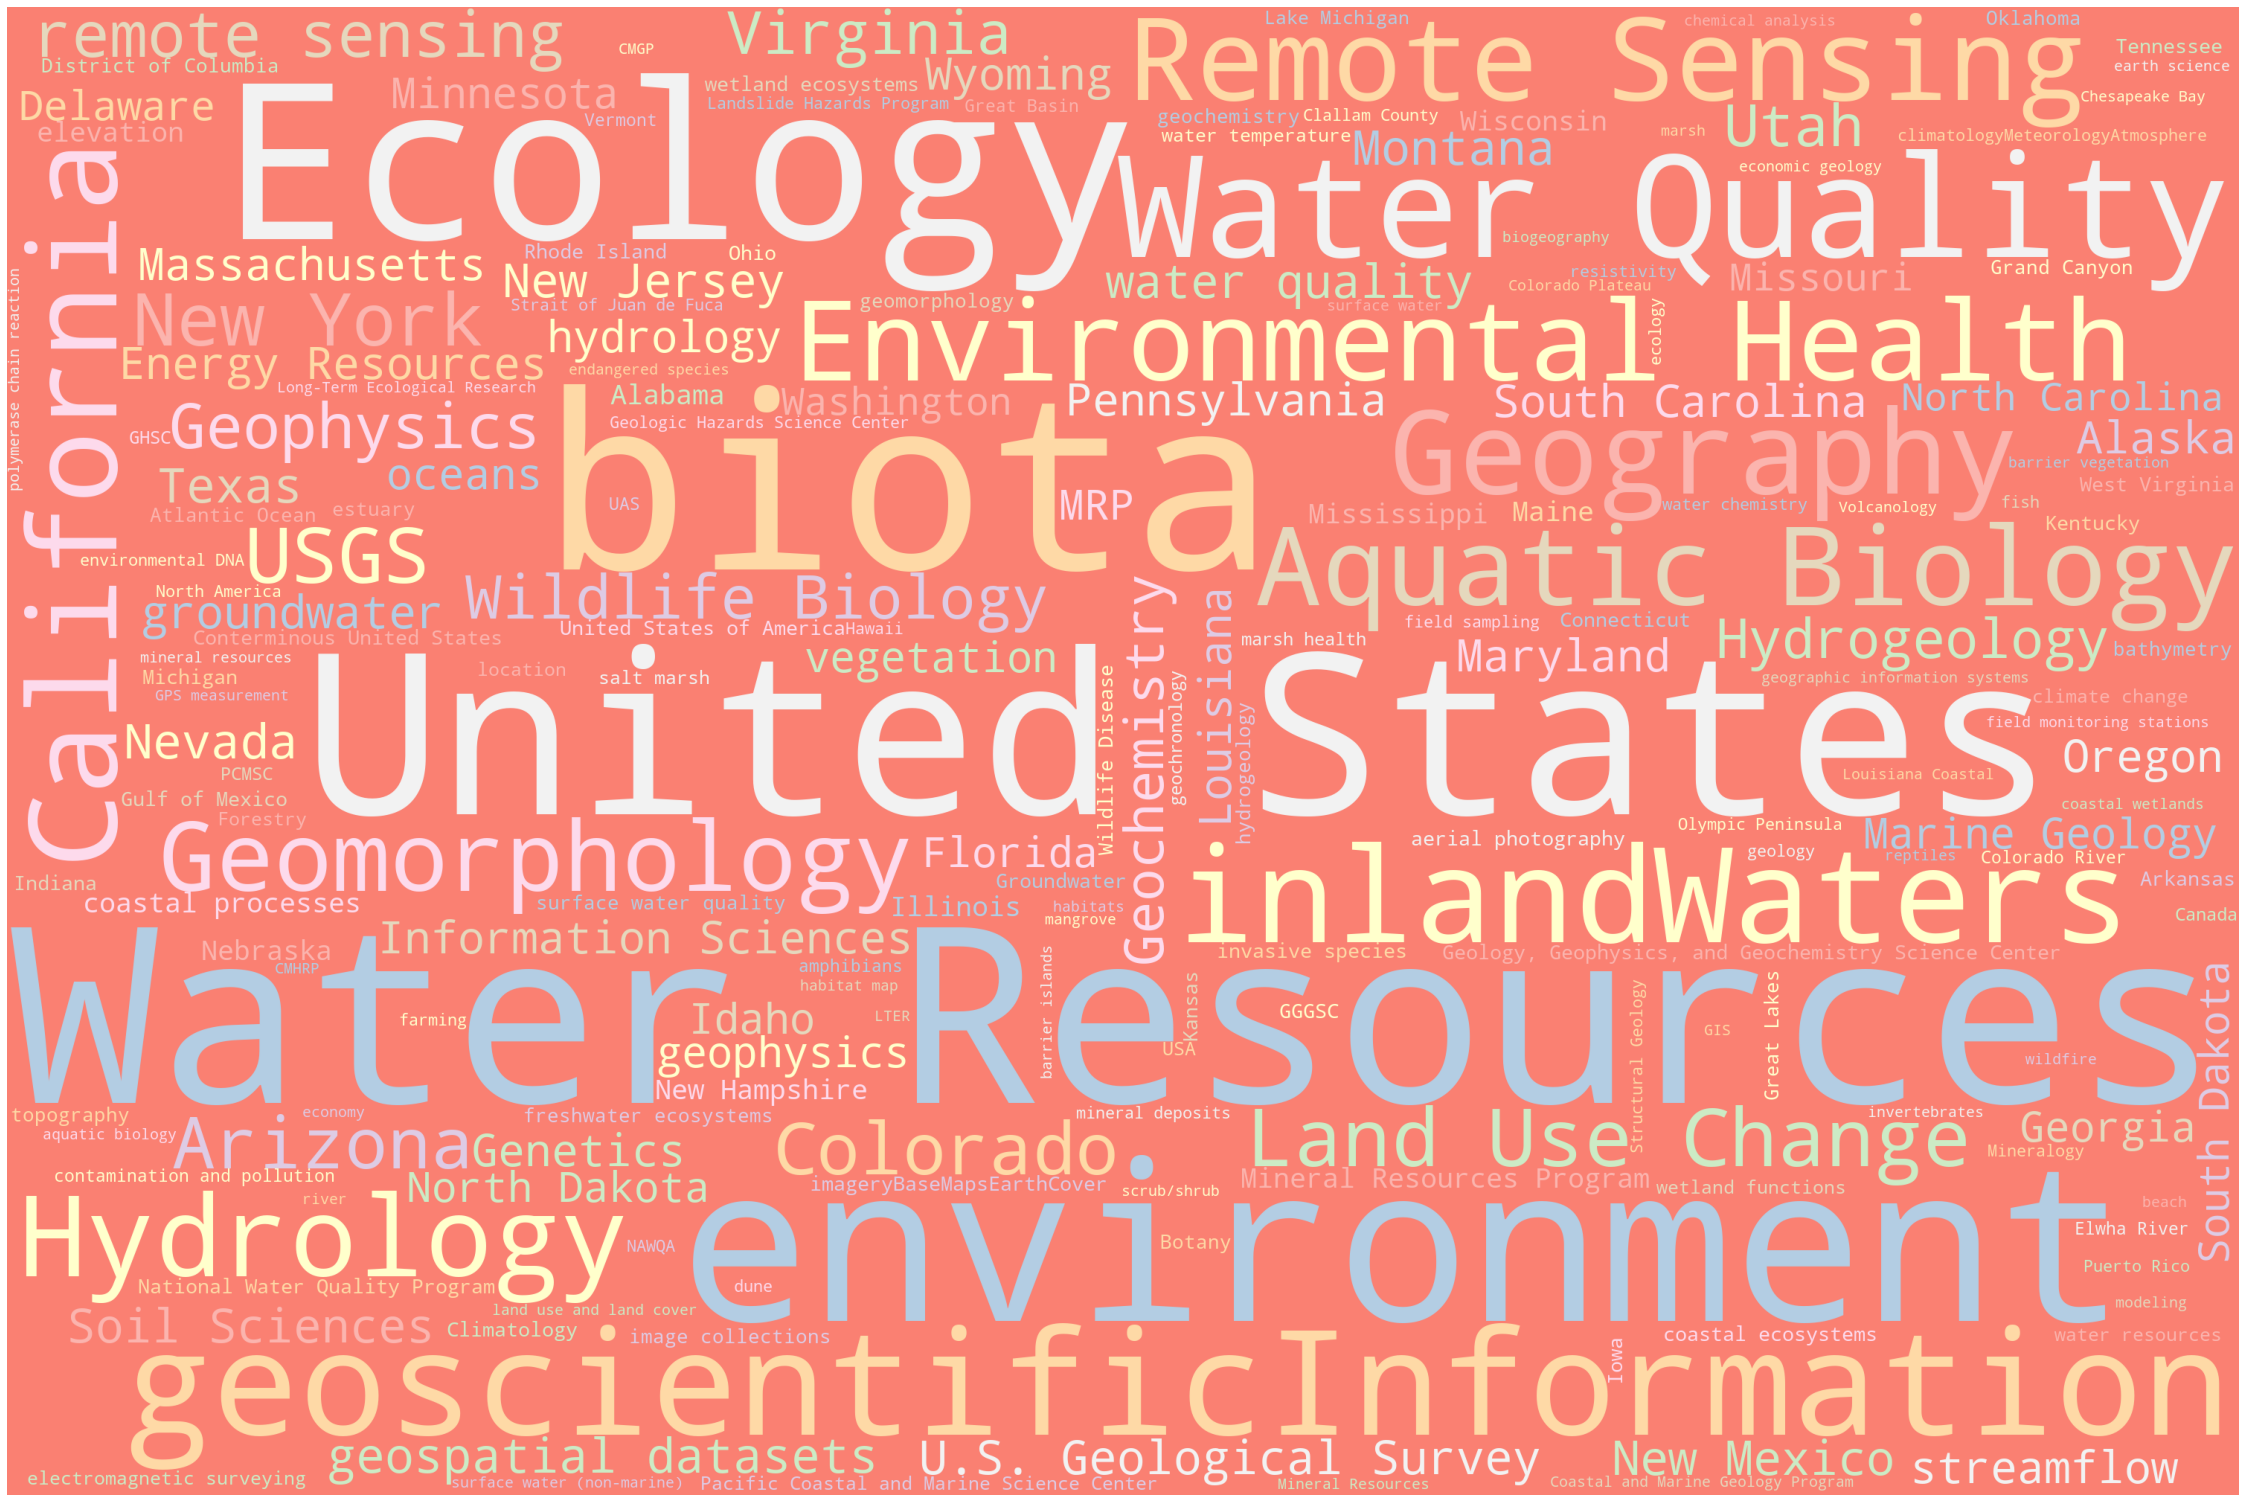

In [12]:
plot_cloud(wc.generate_from_frequencies(Counter(cdi_data_tags)))